# Explore here

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
data = pd.read_csv(url) 

In [221]:
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [222]:
data['date'] = pd.to_datetime(data['date']).dt.normalize()
# data['date'] = data["date"].dt.strftime('%Y-%m-%d') # con esto daba error
# data['date'] = pd.to_datetime(data['date'])
data = data.set_index("date")
ts = data["sales"]  # time series

In [223]:
data

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633
...,...
2023-08-30,989.600354
2023-08-31,994.987326
2023-09-01,995.814415


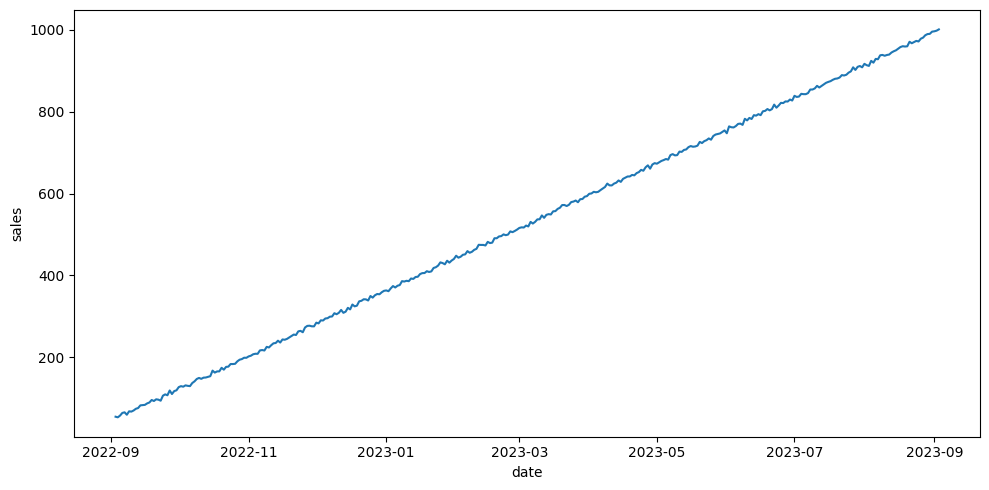

In [224]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

In [225]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period = 24) # o nada y que la función lo detecte
decomposition

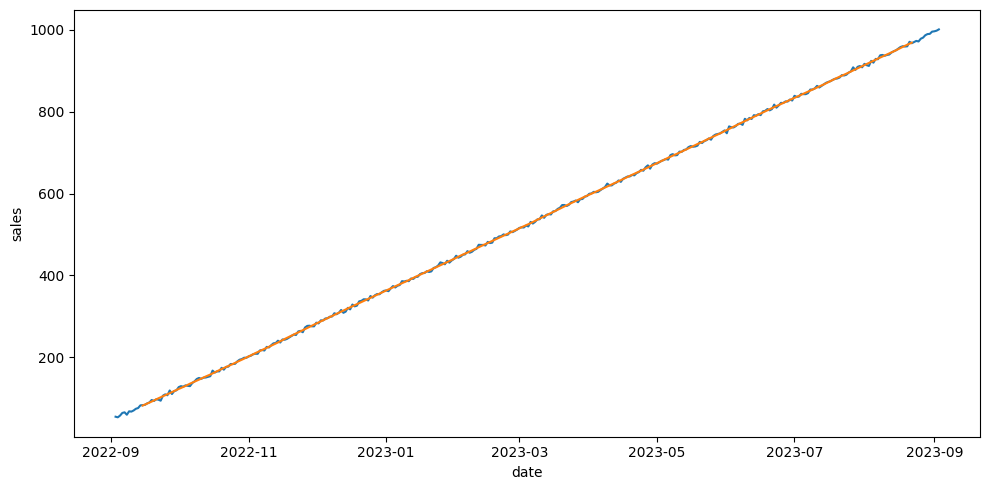

In [226]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

#### Seasonality analysis

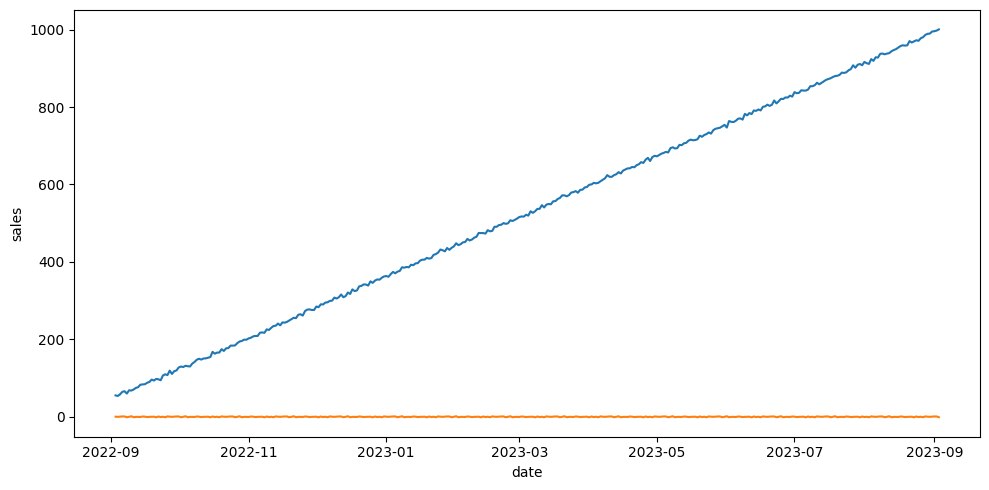

In [227]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [228]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# p-value < 0.05 es la hipótesis nula. Se rechaza la hipótesis nula y por tanto nos quedamos con la alternativa.
# Hipótesis nula: Es estacionaria.
# Hipótesis alternativa: No es estacionaria.
test_stationarity(ts)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

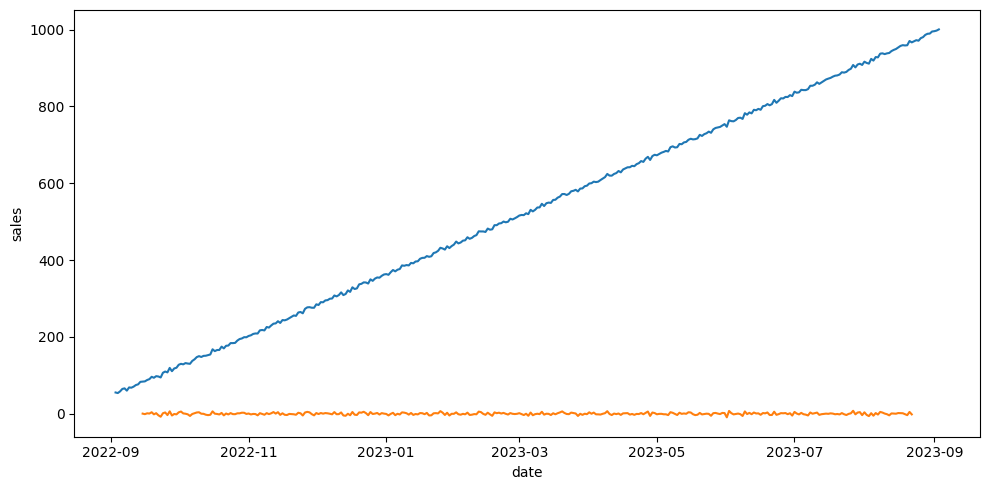

In [229]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

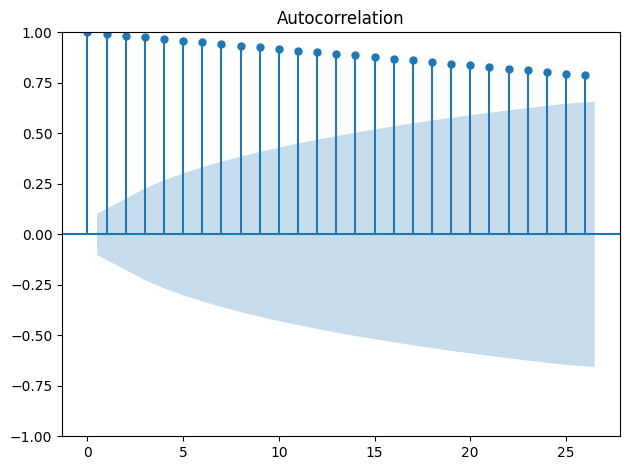

In [230]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye a lo largo del tiempo.

### Paso 3: Entrenamiento del modelo

In [231]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [232]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 24)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=1846.864, Time=5.40 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2096.542, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1972.915, Time=1.27 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1841.580, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2209.657, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=1839.587, Time=0.20 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=1841.583, Time=1.42 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1843.509, Time=2.26 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=1839.553, Time=0.50 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=1841.556, Time=2.73 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=1841.552, Time=2.55 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=1843.462, Time=2.09 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1970.972, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=1841.533, Time=0.67 sec
 ARIMA(1,0,2)(0,0,0

In [233]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Wed, 09 Apr 2025   AIC                           1839.553
Time:                        21:09:30   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [234]:
forecast = model.predict(10)
forecast

2023-09-04    1.675366
2023-09-05    2.673520
2023-09-06    2.591621
2023-09-07    2.598341
2023-09-08    2.597789
2023-09-09    2.597834
2023-09-10    2.597831
2023-09-11    2.597831
2023-09-12    2.597831
2023-09-13    2.597831
Freq: D, dtype: float64

In [235]:
# forecast_df = forecast.reset_index()
# forecast_df.columns = ["date", "value"]



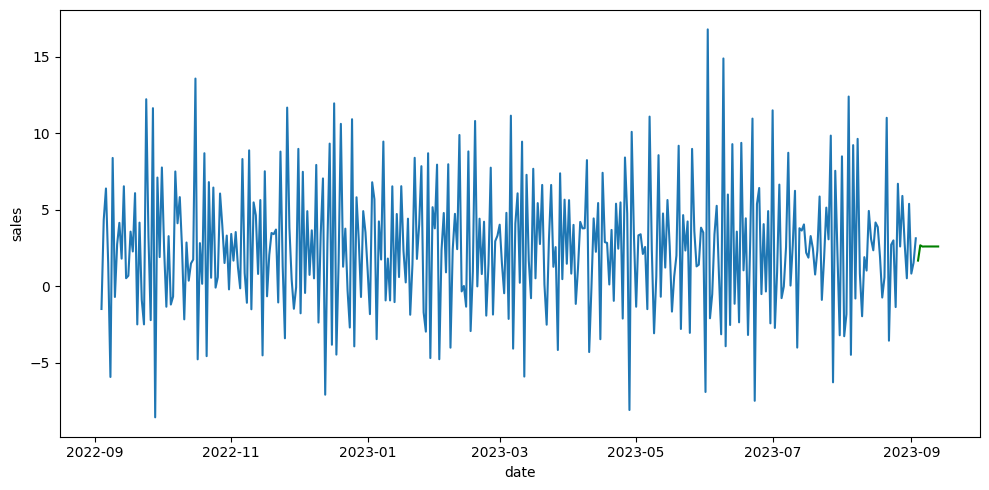

In [236]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
#sns.lineplot(data = forecast, color = "green")
sns.lineplot(data = forecast, color="green")

plt.tight_layout()

plt.show()

Otra forma de representar los gráficos

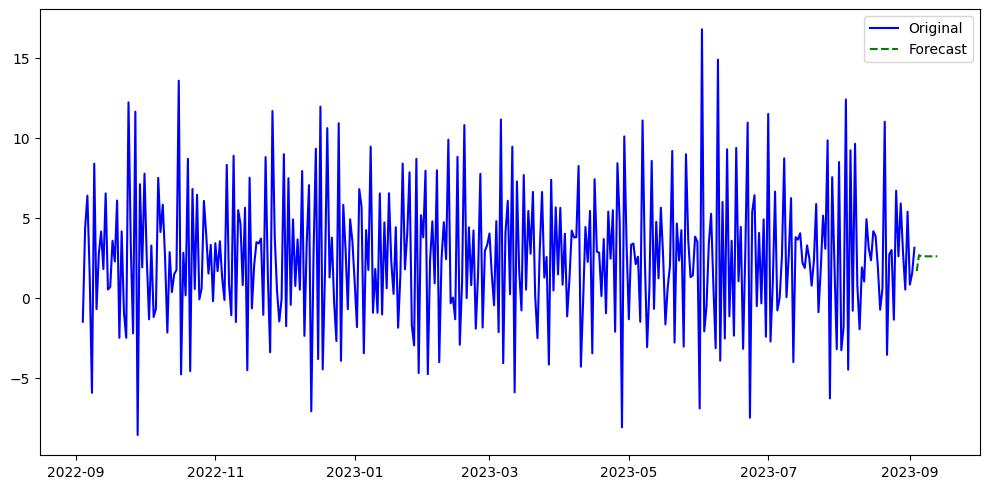

In [237]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize=(10, 5))

# Línea original
axis.plot(ts_stationary.index, ts_stationary.values, label="Original", color="blue")

# Forecast
axis.plot(forecast.index, forecast.values, label="Forecast", color="green", linestyle="--")

axis.legend()
plt.tight_layout()
plt.show()
